In [1]:
import pandas as pd
import numpy as np
from ladybug.epw import EPW
from lightning.pytorch import Trainer
from pathlib import Path

from ml.surrogate import Surrogate
from ml.predict import predict_ubem
from weather.weather import extract


Couldn't import dot_parser, loading of dot files will not be possible.


In [2]:
bucket = "ml-for-bem"
remote_experiment = "full_climate_zone/v5"
local_data_dir = "data/lightning"

registry = "ml-for-building-energy-modeling/model-registry"
model = "Global UBEM Shoebox Surrogate with Combined TS Embedder"
tag = "v1"
resource = "model-with-transform-configs.ckpt"

surrogate = Surrogate.load_from_registry(registry, model, tag, resource)
surrogate.model.eval()

trainer = Trainer(
        accelerator="auto",
        devices="auto",
        strategy="auto",
        enable_progress_bar=True,
    )

c:\tools\Anaconda3\envs\ml-for-bem-final\lib\site-packages\lightning\pytorch\utilities\parsing.py:198: Attribute 'target_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['target_transform'])`.
c:\tools\Anaconda3\envs\ml-for-bem-final\lib\site-packages\lightning\pytorch\utilities\parsing.py:198: Attribute 'weather_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['weather_transform'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [3]:
sin_schedule = np.linspace(0,2*np.pi*365-1/24*2*np.pi,365*24)
sin_schedule = -np.cos(sin_schedule)/2 + 0.5
schedules = np.stack([sin_schedule]*3).reshape(1,3,8760)

In [4]:
epw = EPW("/teamspace/uploads/USA_NY_New.York-LaGuardia.AP.725030_TMYx.2004-2018.epw")
epw = EPW("C:/ProgramData/Solemma/Common/WeatherData/EPW/USA_CA_Los.Angeles.Intl.AP.722950_TMYx.2004-2018.epw")
epw = EPW("C:/ProgramData/Solemma/Common/WeatherData/EPW/USA_MA_Boston-Logan.Intl.AP.725090_TMYx.2004-2018.epw")
epw = EPW("C:/ProgramData/Solemma/Common/WeatherData/EPW/USA_NY_New.York-LaGuardia.AP.725030_TMYx.2004-2018.epw")
# epw = EPW("/teamspace/uploads/USA_CA_Los.Angeles.Intl.AP.722950_TMYx.2004-2018.epw")
# epw = EPW("/teamspace/uploads/USA_MA_Boston-Logan.Intl.AP.725090_TMYx.2004-2018.epw")
climate = extract(epw)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\tools\Anaconda3\envs\ml-for-bem-final\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 13/13 [00:00<00:00, 29.89it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\tools\Anaconda3\envs\ml-for-bem-final\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 13/13 [00:00<00:00, 30.46it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\tools\Anaconda3\envs\ml-for-bem-final\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 13/13 [00:00<00:00, 30.60it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\tools\Anaconda3\envs\ml-for-bem-final\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 13/13 [00:00<00:00, 30.46it/s]
0.25


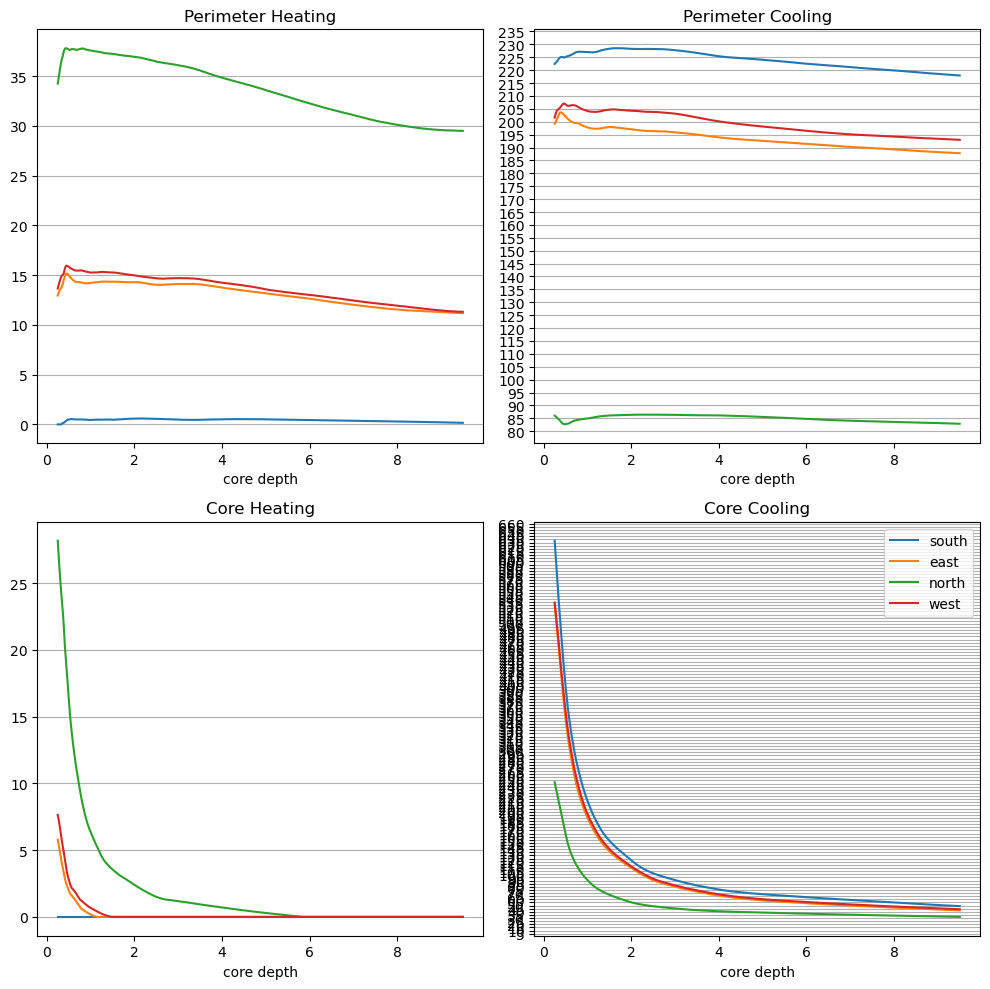

In [79]:
fig, axs = plt.subplots(2,2,figsize=(10,10))
for or_ix in range(4):
    config = {
        "FacadeMass": 1,
        "RoofMass": 1,
        "FacadeRValue": 4.88,
        "RoofRValue": 4.88,
        "SlabRValue": 4.88,
        "WindowUValue": 4.0,
        "WindowShgc": 0.75,
        "PeopleDensity": 0.025,
        "EquipmentPowerDensity": 3,
        "LightingPowerDensity": 3,
        "HeatingSetpoint": 20,
        "CoolingSetpoint": 24,
        "cop_heating": 1,
        "cop_cooling": 1,
        "VentilationMode": 1,
        "VentilationPerArea": 0.0000,
        "VentilationPerPerson": 0.000,
        "EconomizerSettings": 0,
        "RecoverySettings": 0,
        "Infiltration": 0.0002,
        "wwr": 0.5,
        "template_idx": 0,
        "width": 3,
        "height": 5,
        "floor_2_facade": 1,
        "building_id": 0,
        "roof_2_footprint": 0,
        "ground_2_footprint": 0,
        "core_2_perim": 1,
        "orientation": or_ix,
        "weight": 1,
    }
    for i in range(12):
        config[f"shading_{i}"] = 0

    n_samples = 400
    features = pd.DataFrame(data=config, index=[0])
    features = pd.concat([features]*n_samples,axis=0)

    features["core_2_perim"] = np.linspace(0.05,1.9,n_samples)

    shoebox_results, *_ = predict_ubem(trainer=trainer, surrogate=surrogate, features=features,schedules=schedules, climate=climate,apply_cops=False, batch_size=32,)

    annual = shoebox_results.T.groupby(level=[0,1]).sum().T

    import matplotlib.pyplot as plt
    from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)

    axs = axs.flatten()
    core_depth = features["height"] * features["floor_2_facade"] * features["core_2_perim"]
    core_depth = core_depth.values
    orientations = ["south","east","north","west"]
    axs[0].plot(core_depth, annual["Perimeter"]["Heating"].values, label=orientations[or_ix])
    axs[1].plot(core_depth, annual["Perimeter"]["Cooling"].values, label=orientations[or_ix])
    axs[2].plot(core_depth, annual["Core"]["Heating"].values, label=orientations[or_ix])
    axs[3].plot(core_depth, annual["Core"]["Cooling"].values, label=orientations[or_ix])
    axs[0].set_title("Perimeter Heating")
    axs[1].set_title("Perimeter Cooling")
    axs[2].set_title("Core Heating")
    axs[3].set_title("Core Cooling")

for i in range(4):
    # axs[i].set_ylim([0,120])
    axs[i].set_xlabel("core depth")
    axs[i].yaxis.set_major_locator(MultipleLocator(5))
    axs[i].grid(axis="y")
fig.tight_layout()
plt.legend()
print(core_depth.min())